In [1]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
matplotlib.use('qt5agg')
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from simulated_utils import SimpleEnv, sample_trajectories_by_batch_size, get_obs_acs_rewards_advs
from simulated_utils import base_params, comparisons
from policy_gradients.models import CtsPolicy, CtsBetaPolicy
from policy_gradients.steps import ppo_step
from policy_gradients.torch_utils import Parameters

In [36]:
def step(env, policy, params):
    trajs, steps_in_trajs = sample_trajectories_by_batch_size(env, policy, 128, 100)
    obs, acs, rewards, advs = get_obs_acs_rewards_advs(trajs)
    obs = torch.Tensor(obs)
    acs = torch.Tensor(acs)
    advs = torch.Tensor(advs)
    with torch.no_grad():
        old_pds = policy(obs)
        old_log_ps = policy.get_loglikelihood(old_pds, acs)
    loss = ppo_step(obs, acs, old_log_ps, None, None, None, advs, policy, params, None, None)
    return_dict = {
        'loss': loss.detach().item(),
        'mean_reward': np.mean(rewards)
    }
    for i, pd_param in enumerate(old_pds):
        return_dict[f'pd_param_{i}_mean'] = np.mean(pd_param.numpy())
    return return_dict
    
def train(env, policy, params, n_steps):
    df = pd.DataFrame()
    for i in range(n_steps):
        return_dict = step(env, policy, params)
        return_dict['iter'] = i
        df = df.append(return_dict, ignore_index=True)
    return df

In [76]:
def compare(n_steps=20, lr=5e-3, repeats=10, seed=0, policy_cls=CtsPolicy, **kwargs):
    np.random.seed(seed)
    env = SimpleEnv()
    base_params.update(**kwargs)
    data = None
    for i, name in enumerate(comparisons.keys()):
        params = base_params.copy()
        params.update(comparisons[name])
        for j in range(repeats):
            policy = policy_cls(env.obs_dim, env.action_dim, init='xavier', hidden_sizes=[10],
                                action_space_low=env.action_space.low,
                                action_space_high=env.action_space.high)
            params['policy_adam'] = torch.optim.Adam(policy.parameters(), lr=lr)
            data_this_run = train(env, policy, Parameters(params), n_steps)
            data_this_run['method'] = name
            if data is None:
                data = data_this_run
            else:
                data = pd.concat([data, data_this_run])
    return data

In [144]:
data = compare(n_steps=100, repeats=10, lr=1e-2)

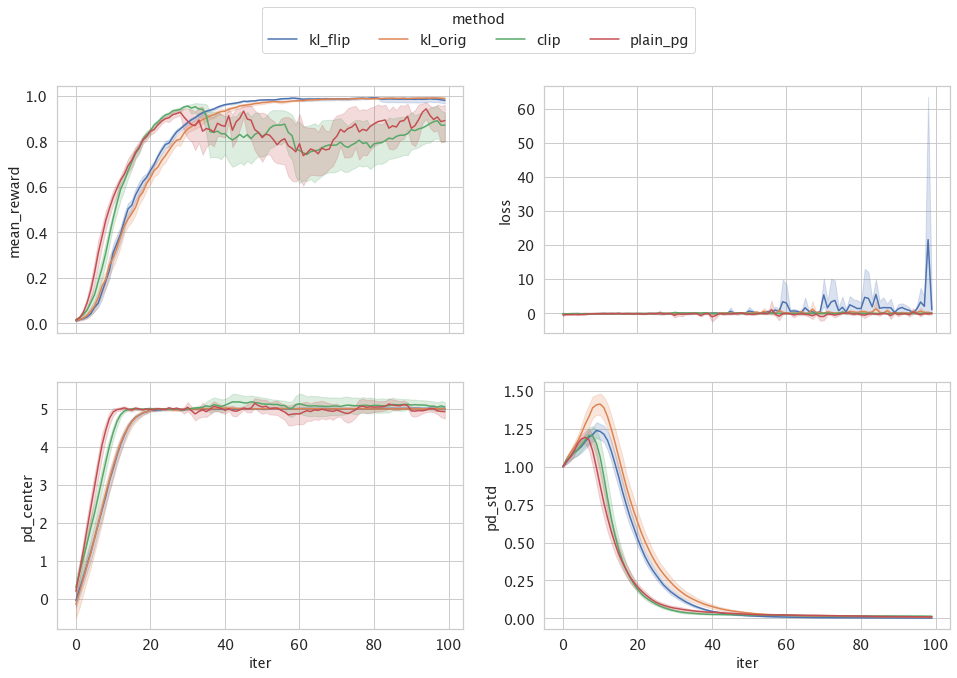

In [146]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
sns.lineplot(data=data, x='iter', y='mean_reward', hue='method', ax=axes[0][0])
sns.lineplot(data=data, x='iter', y='loss', hue='method', ax=axes[0][1])
sns.lineplot(data=data, x='iter', y='pd_center', hue='method', ax=axes[1][0])
sns.lineplot(data=data, x='iter', y='pd_std', hue='method', ax=axes[1][1])

handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    ax.get_legend().remove()
fig.legend(handles[1:], labels[1:], loc='upper center', title='method', ncol=4)
plt.show()

In [7]:
np.std(np.concatenate([np.arange(300), 300*np.ones(2000)]))

59.559016655988835

In [67]:
data = compare(n_steps=1000, repeats=10, lr=1e-2, policy_cls=CtsBetaPolicy)

In [70]:
data

,iter,loss,mean_reward,pd_param_0_mean,pd_param_1_mean,method
0,0.0,-0.048127,0.113164,1.828747,1.686162,kl_flip
1,1.0,0.004196,0.113270,2.051985,1.575006,kl_flip
2,2.0,-0.035257,0.156303,2.283448,1.504040,kl_flip
3,3.0,-0.057025,0.184443,2.550585,1.461876,kl_flip
4,4.0,-0.007176,0.165798,2.789160,1.450316,kl_flip
...,...,...,...,...,...,...
995,995.0,-0.000921,0.583887,109.867905,36.699253,plain_pg
996,996.0,-0.001352,0.610500,110.031464,36.636806,plain_pg
997,997.0,-0.001129,0.590017,110.129036,36.640049,plain_pg
998,998.0,0.002591,0.600702,110.241241,36.649929,plain_pg


In [72]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
sns.lineplot(data=data, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=100)
sns.lineplot(data=data, x='iter', y='loss', hue='method', ax=axes[0][1], n_boot=100)
sns.lineplot(data=data, x='iter', y='pd_param_0_mean', hue='method', ax=axes[1][0], n_boot=100)
sns.lineplot(data=data, x='iter', y='pd_param_1_mean', hue='method', ax=axes[1][1], n_boot=100)

handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    ax.get_legend().remove()
fig.legend(handles[1:], labels[1:], loc='upper center', title='method', ncol=4)
plt.savefig('simple_env_1d_sim_beta.png')

In [77]:
data_single = compare(n_steps=1000, repeats=1, lr=1e-1, policy_cls=CtsBetaPolicy)

//anaconda3/envs/ppo/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [78]:
data_single

,iter,loss,mean_reward,pd_param_0_mean,pd_param_1_mean,method
0,0.0,-0.098385,0.154582,1.744611,1.731249,kl_flip
1,1.0,-0.001972,0.117336,2.004774,1.696166,kl_flip
2,2.0,0.016921,0.129331,2.267451,1.534275,kl_flip
3,3.0,-0.061310,0.170042,2.897428,1.549867,kl_flip
4,4.0,0.024404,0.212057,4.076834,1.765844,kl_flip
...,...,...,...,...,...,...
995,995.0,-0.011012,0.835514,1150.462036,384.617004,plain_pg
996,996.0,-0.109268,0.847113,1152.728271,383.623169,plain_pg
997,997.0,0.023087,0.856144,1150.979980,386.484314,plain_pg
998,998.0,-0.075327,0.858697,1151.810547,386.893250,plain_pg


In [79]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
sns.lineplot(data=data_single, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=100)
sns.lineplot(data=data_single, x='iter', y='loss', hue='method', ax=axes[0][1], n_boot=100)
sns.lineplot(data=data_single, x='iter', y='pd_param_0_mean', hue='method', ax=axes[1][0], n_boot=100)
sns.lineplot(data=data_single, x='iter', y='pd_param_1_mean', hue='method', ax=axes[1][1], n_boot=100)

handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    ax.get_legend().remove()
fig.legend(handles[1:], labels[1:], loc='upper center', title='method', ncol=4)
plt.savefig('simple_env_1d_sim_beta.png')